# Credit Score Simulator with finite samples

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

#### Experimental setup arguments

In [2]:
# Experimental setup arguments

class args:

    # softness parameter for the sigmoid approximating the indicator function, 1 = normal, inf = indicator
    softness = 10

    # risk control parameter
    alpha = 0.05

    # risk control probability (delta_prime)
    delta = 0.1

    # epsilon
    epsilon = 1e2


In [3]:
from data_prep import load_data

path_to_csv_file = './data/cs-training.csv'
X, Y, data = load_data(path_to_csv_file)

n = X.shape[0]
d = X.shape[1] - 1

print('n=',n)
print('d=',d)

n= 18357
d= 10


#### iii) Pretrained classifier: $f_{\theta}$

Train a logistic regression model

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

def sigmoid(X):
    return 1 / (1 + np.exp(-X))

def soft_loss(Y, Y_prob, softness, threshold):
    """Evaluates y_true * sigmoid(softness * (1 - threshold - Y_prob))"""
    return np.mean(
        Y * sigmoid(softness * (1 - threshold - Y_prob))
    )

def type_II_error(Y, Y_pred):
    return np.mean(
        (Y == 1) & (Y_pred == 0)
    )


model = LogisticRegression(fit_intercept=False)  # intercept pre-built in X
model.fit(X, Y)
assert model.classes_[0] == 0 and model.classes_[1] == 1

example_thresh = 0.5
Y_proba = model.predict_proba(X)[:,1]
Y_pred = Y_proba > example_thresh


print(f" ----- example_thresh = {example_thresh} -----")
for softness in [1, 10, 100, 1000]:
    print(f"Soft loss @ softness = {softness}: ", soft_loss(Y, Y_proba, softness, example_thresh))

print("Accuracy: ", accuracy_score(Y, Y_pred))
print("Type II error: ", type_II_error(Y, Y_pred))

 ----- example_thresh = 0.5 -----
Soft loss @ softness = 1:  0.22137793473017475
Soft loss @ softness = 10:  0.19943491532667956
Soft loss @ softness = 100:  0.21017386090960746
Soft loss @ softness = 1000:  0.21116160598814404
Accuracy:  0.7192351691452852
Type II error:  0.21125456229231357


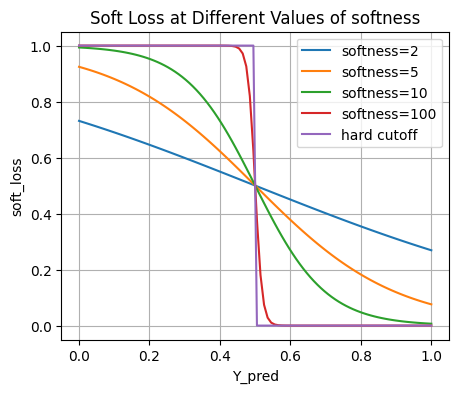

In [26]:
threshold = 0.5
Y_proba = np.linspace(0, 1, 100)

plt.figure(figsize=(5,4))
for softness in [2, 5, 10, 100]:
    plt.plot(Y_proba, sigmoid(softness * (1 - threshold - Y_proba)), label=f'softness={softness}')
# indicator
plt.plot(Y_proba, (Y_proba <= threshold).astype(int), label='hard cutoff')

plt.xlabel('Y_pred')
plt.ylabel('soft_loss')
plt.title('Soft Loss at Different Values of softness')
plt.legend()
plt.grid(True)
plt.show()

## Simulations

In [27]:
def get_updated_thresh(Y_cal, Y_cal_proba, softness, delta, error_bound=1e-6):
    """Updates the threshold
    
    Assumes constant n throughout time.
    """

    n = len(Y_cal)
    bound = args.alpha - np.sqrt((1. / 2 / n) * np.log(1 / delta))

    partial_loss = lambda threshold: soft_loss(Y_cal, Y_cal_proba, softness, threshold)

    # determine min threshold at which risk is controlled
    low, high = 0, 1
    while high - low > error_bound:
        mid = (low + high) / 2
        if partial_loss(mid) > bound:
            low = mid
        else:
            high = mid
    return (low + high) / 2


In [28]:
# strategic feature indices
strat_features = np.array([1, 6, 8]) - 1 # for later

print('Strategic Features: \n')
for i, feature in enumerate(strat_features):
    print(i, data.columns[feature + 1])

# zero out strategic features
assert model.coef_.shape == (1, d+1) 
strat_coef = np.zeros((1, d+1))
strat_coef[0, strat_features] = model.coef_[0, strat_features]

Strategic Features: 

0 RevolvingUtilizationOfUnsecuredLines
1 NumberOfOpenCreditLinesAndLoans
2 NumberRealEstateLoansOrLines


In [29]:
# best response function for agents, linear utilities quadratic costs
def best_response(X, Y_proba, threshold, epsilon, softness):
    # Assume very utility function is soft threshold
    # Calculate the best response by computing the derivative of 
    # the utility minus the cost

    # apply chain rule
    soft_indicator_deriv = sigmoid(softness * (1 - threshold - Y_proba))
    soft_indicator_deriv *= (1 - soft_indicator_deriv)  # soft indicator fn

    proba_deriv = - softness * Y_proba * (1 - Y_proba)  # predictor

    deriv_scale = (soft_indicator_deriv * proba_deriv).reshape(-1, 1)  # based on threshold

    X_strat = X + epsilon * deriv_scale * strat_coef

    return X_strat

#### Risk Control Under Performativity

- Distributional changes under algorithm: store histograms


- Visualize distribution changes under algorithm
- Compare to binary search
    - empirical loss through iterations
    - soft loss / hard loss on threshold throughout iterations
- Experiment w/ different epsilon's, softness

In [30]:
class Logger:
    def __init__(self):
        self.data = {}

    def update(self, step, values):
        for key, value in values.items():
            if key not in self.data:
                self.data[key] = {}
            self.data[key][step] = value

    def get_data(self, key):
        sorted_data = sorted(self.data[key].items())
        return zip(*sorted_data)  # steps, values

In [59]:
def run_iters(model, X, Y, args, thresh_low=0., thresh_high=1., total_iter=20, random_state=123, method='ucb'):
    """
    model: pretrained logistic regression
    X, Y: data
    total_iter: number of steps
    random_state: random seed for splitting data
    method: 'ubc' or 'bin_search'
    """

    from sklearn.model_selection import train_test_split

    # X_val, X_cal, Y_val_proba, Y_cal_proba are static b/c they are from the base distribution
    X_cal, X_val, Y_cal, Y_val = train_test_split(X, Y, train_size=5000, random_state=random_state)
    Y_val_proba = model.predict_proba(X_val)[:,1]
    Y_cal_proba = model.predict_proba(X_cal)[:,1]

    thresh = thresh_high  # be defensive on first threshold initialization

    logger = Logger()
    Y_cal_hist = np.histogram(Y_cal_proba, np.linspace(0, 1, 101))
    Y_val_hist = np.histogram(Y_val_proba, np.linspace(0, 1, 101))
    logger.update(0, {"Y_cal_hist": Y_cal_hist, "Y_val_hist": Y_val_hist, "thresh": thresh})

    for iter in range(total_iter):

        # Deploy threshold of time t and get data of time t
        X_val_iter = best_response(X_val, Y_val_proba, thresh, args.epsilon, args.softness)
        X_cal_iter = best_response(X_cal, Y_cal_proba, thresh, args.epsilon, args.softness)
        Y_val_proba_iter = model.predict_proba(X_val_iter)[:,1]
        Y_cal_proba_iter = model.predict_proba(X_cal_iter)[:,1]

        # Update threshold t -> t+1
        if method == 'ucb':
            thresh_new = get_updated_thresh(Y_cal, Y_cal_proba_iter, args.softness, args.delta)
        else:
            thresh_new = (thresh_low + thresh_high) / 2

        # Evaluate to get empirical risk on cal set and a proxy for population risk (using updated thresh)
        # Assume ground truth doesn't change
        loss_val = soft_loss(Y_val, Y_val_proba_iter, args.softness, thresh_new)
        loss_cal = soft_loss(Y_cal, Y_cal_proba_iter, args.softness, thresh_new)
        type_II_error_val = type_II_error(Y_val, Y_val_proba_iter > thresh_new)
        type_II_error_cal = type_II_error(Y_cal, Y_cal_proba_iter > thresh_new)

        if method == 'bin_search':
            if loss_cal > args.alpha:  # violation
                thresh_low = thresh_new
            else:
                thresh_high = thresh_new

        # Monitor distribution shifts
        Y_val_hist = np.histogram(Y_val_proba_iter, np.linspace(0, 1, 101))
        Y_cal_hist = np.histogram(Y_cal_proba_iter, np.linspace(0, 1, 101))

        # Log
        logger.update(iter+1,
                    {"loss_val": loss_val, "loss_cal": loss_cal,
                    "type_II_error_val": type_II_error_val, "type_II_error_cal": type_II_error_cal,
                    "Y_cal_hist": Y_cal_hist, "Y_val_hist": Y_val_hist,
                    "thresh": thresh_new})

        # Update threshold
        thresh = thresh_new

    return logger

In [60]:
def plot_histogram_evolution(logger):

    steps, Y_val_hist_all = logger.get_data("Y_cal_hist")
    Y_val_hist_all = [hist[0] for hist in Y_val_hist_all]

    _, thresh_all = logger.get_data("thresh")

    hist_data = np.array(Y_val_hist_all)

    # Plot heatmap
    plt.figure(figsize=(8, 4))
    plt.imshow(hist_data.T, aspect='auto', cmap='viridis', origin='lower')
    plt.plot(range(len(thresh_all)), 100 - np.array(thresh_all) * 100, color='red', linestyle="--", linewidth=2, label=r'1-$\lambda$')

    yticks = np.linspace(0, 100, 11)  # Tick positions on the 0-100 scale
    yticklabels = [f"{y/100:.1f}" for y in yticks]  # Format tick labels to 2 decimal places
    plt.gca().set_yticks(yticks)
    plt.gca().set_yticklabels(yticklabels)

    plt.colorbar(label='Count')
    plt.xlabel('iteration')
    plt.ylabel('predicted default probability')
    plt.title(r'$f_{\theta}(x)$ histogram evolution')
    plt.legend()
    plt.show()


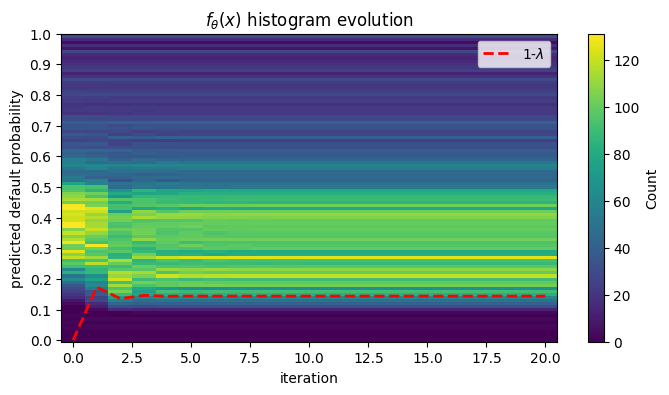

In [61]:
# algorithm aproach
logger = run_iters(model, X, Y, args, total_iter=20, random_state=123)
plot_histogram_evolution(logger)

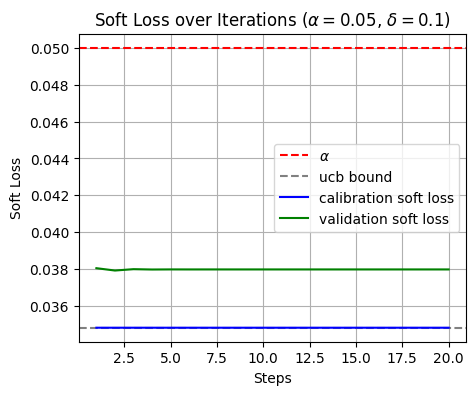

In [69]:
def show_loss_over_iter(logger, alpha, delta, n=5000):
    """
    alpha: risk control level
    delta: risk conrol probability (1 - delta = probability)
    """

    steps, loss_cal = logger.get_data("loss_cal")
    _, loss_val = logger.get_data("loss_val")
    _, type_II_error_cal = logger.get_data("type_II_error_cal")
    _, type_II_error_val = logger.get_data("type_II_error_val")

    plt.figure(figsize=(5, 4))
    plt.rcParams['text.usetex'] = False

    # Risk to control
    plt.axhline(alpha, color='r', linestyle='--', label=r'$\alpha$')

    hoeff_risk = alpha - np.sqrt((1. / 2 / n) * np.log(1 / delta))
    plt.axhline(hoeff_risk, color='gray', linestyle='--', label="ucb bound")

    plt.plot(steps, loss_cal, label='calibration soft loss', color='b')
    plt.plot(steps, loss_val, label='validation soft loss', color='g')
    # plt.plot(steps, type_II_error_cal, label='calibration hard loss', color='b', linestyle='--')
    # plt.plot(steps, type_II_error_val, label='validation hard loss', color='g', linestyle='--')

    plt.xlabel('Steps')
    plt.ylabel('Soft Loss')
    plt.title(rf'Soft Loss over Iterations ($\alpha={alpha}$, $\delta={delta}$)')
    plt.legend()
    plt.grid(True)
    plt.show()

show_loss_over_iter(logger, args.alpha, args.delta)

#### Binary search

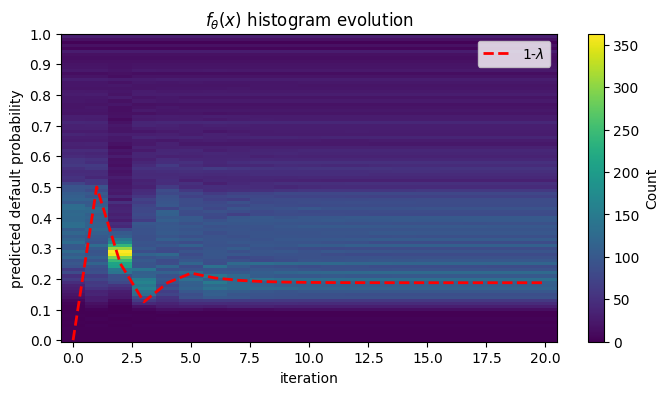

In [70]:
# Run over different seeds
# Run over binary search

bin_search_logger = run_iters(model, X, Y, args, total_iter=20, random_state=123, method='bin_search')
plot_histogram_evolution(bin_search_logger)

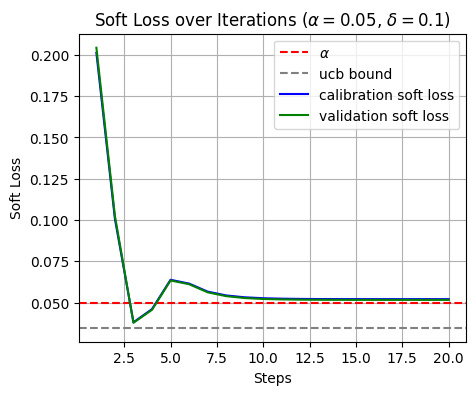

In [71]:
show_loss_over_iter(bin_search_logger, args.alpha, args.delta)

In [75]:
n

18357

#### Confidence Bounds

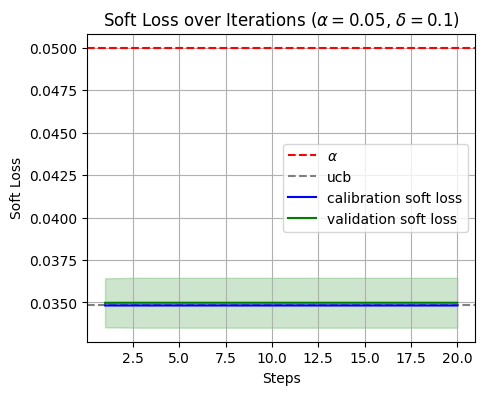

In [77]:
alpha = args.alpha
delta = args.delta
n = 5000

loggers = [
    run_iters(model, X, Y, args, total_iter=20, random_state=i, method='ucb') for i in range(100)
]

plt.figure(figsize=(5, 4))
plt.rcParams['text.usetex'] = False


loss_cals, loss_vals, type_II_error_cals, type_II_error_vals = [], [], [], []

for logger in loggers:
    steps, loss_cal = logger.get_data("loss_cal")
    _, loss_val = logger.get_data("loss_val")
    _, type_II_error_cal = logger.get_data("type_II_error_cal")
    _, type_II_error_val = logger.get_data("type_II_error_val")
    loss_cals.append(loss_cal)
    loss_vals.append(loss_val)
    type_II_error_cals.append(type_II_error_cal)
    type_II_error_vals.append(type_II_error_val)

# Collapse to find mean and std
loss_cals_mean = np.mean(loss_cals, axis=0)
loss_vals_mean = np.mean(loss_vals, axis=0)
type_II_error_cals_mean = np.mean(type_II_error_cals, axis=0)
type_II_error_vals_mean = np.mean(type_II_error_vals, axis=0)

loss_cals_std = np.std(loss_cals, axis=0)
loss_vals_std = np.std(loss_vals, axis=0)
type_II_error_cals_std = np.std(type_II_error_cals, axis=0)
type_II_error_vals_std = np.std(type_II_error_vals, axis=0)


# Risk to control
plt.axhline(alpha, color='r', linestyle='--', label=r'$\alpha$')
hoeff_risk = alpha - np.sqrt((1. / 2 / n) * np.log(1 / args.delta))
plt.axhline(hoeff_risk, color='gray', linestyle='--', label="ucb")

plt.plot(steps, loss_cals_mean, label='calibration soft loss', color='b')
plt.plot(steps, loss_vals_mean, label='validation soft loss', color='g')
plt.fill_between(steps, loss_cals_mean - loss_cals_std, loss_cals_mean + loss_cals_std, color='b', alpha=0.2)
plt.fill_between(steps, loss_vals_mean - loss_vals_std, loss_vals_mean + loss_vals_std, color='g', alpha=0.2)

# plt.plot(steps, type_II_error_cal, label='calibration hard loss', color='b', linestyle='--')
# plt.plot(steps, type_II_error_val, label='validation hard loss', color='g', linestyle='--')

plt.xlabel('Steps')
plt.ylabel('Soft Loss')
plt.title(rf'Soft Loss over Iterations ($\alpha={alpha}$, $\delta={delta}$)')
plt.legend()
plt.grid(True)
plt.show()